In [2]:
import pandas as pd
import numpy as np

# Project introduction

For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.

# Data Preperation

In [3]:
# generate two data frames containing all of the listing and calendar data for each location
import os
import pandas as pd

directory_path = 'home_rentals/'

# Initialize an empty list to store DataFrames
listing_df = []
calendar_df = []

# Iterate through subdirectories
for subdirectory in os.listdir(directory_path):
    subdirectory_path = os.path.join(directory_path, subdirectory) 

    csv_listing_file_path = os.path.join(subdirectory_path, "listings.csv.gz")
    csv_calendar_file_path = os.path.join(subdirectory_path, "calendar.csv.gz")
    print(csv_listing_file_path)
    print(csv_calendar_file_path)

    df1 = pd.read_csv(csv_listing_file_path)
    df2 = pd.read_csv(csv_calendar_file_path)

    df1['location'] = subdirectory
    df2['location'] = subdirectory

    listing_df.append(df1)
    calendar_df.append(df2)


# Concatenate all DataFrames into a single DataFrame
all_listing_df = pd.concat(listing_df, ignore_index=True)
all_calendar_df = pd.concat(calendar_df, ignore_index=True)

home_rentals/Zurich/listings.csv.gz
home_rentals/Zurich/calendar.csv.gz
home_rentals/Barcelona/listings.csv.gz
home_rentals/Barcelona/calendar.csv.gz
home_rentals/Milan/listings.csv.gz
home_rentals/Milan/calendar.csv.gz
home_rentals/Valencia/listings.csv.gz
home_rentals/Valencia/calendar.csv.gz
home_rentals/Mallorca/listings.csv.gz
home_rentals/Mallorca/calendar.csv.gz
home_rentals/Washington/listings.csv.gz
home_rentals/Washington/calendar.csv.gz
home_rentals/Rotterdam/listings.csv.gz
home_rentals/Rotterdam/calendar.csv.gz
home_rentals/Tokyo/listings.csv.gz
home_rentals/Tokyo/calendar.csv.gz
home_rentals/Los Angeles/listings.csv.gz
home_rentals/Los Angeles/calendar.csv.gz
home_rentals/Lisbon/listings.csv.gz
home_rentals/Lisbon/calendar.csv.gz
home_rentals/Ireland/listings.csv.gz
home_rentals/Ireland/calendar.csv.gz
home_rentals/Mexico City/listings.csv.gz
home_rentals/Mexico City/calendar.csv.gz
home_rentals/Madrid/listings.csv.gz
home_rentals/Madrid/calendar.csv.gz
home_rentals/Genev

In [4]:
all_calendar_df

,listing_id,date,available,price,adjusted_price,minimum_nights,maximum_nights,location
0,73282,2022-09-23,f,$100.00,$100.00,1125.0,1125.0,Zurich
1,73282,2022-09-24,f,$100.00,$100.00,1125.0,1125.0,Zurich
2,73282,2022-09-25,f,$100.00,$100.00,1125.0,1125.0,Zurich
3,73282,2022-09-26,f,$100.00,$100.00,1125.0,1125.0,Zurich
4,73282,2022-09-27,f,$100.00,$100.00,1125.0,1125.0,Zurich
...,...,...,...,...,...,...,...,...
124889345,1825432,2023-09-24,t,$150.00,$140.00,2.0,1125.0,Malaga
124889346,1825432,2023-09-25,t,$150.00,$140.00,2.0,1125.0,Malaga
124889347,1825432,2023-09-26,t,$150.00,$140.00,2.0,1125.0,Malaga
124889348,1825432,2023-09-27,t,$150.00,$140.00,2.0,1125.0,Malaga


In [5]:
all_listing_df.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'source', 'name',
       'description', 'neighborhood_overview', 'picture_url', 'host_id',
       'host_url', 'host_name', 'host_since', 'host_location', 'host_about',
       'host_response_time', 'host_response_rate', 'host_acceptance_rate',
       'host_is_superhost', 'host_thumbnail_url', 'host_picture_url',
       'host_neighbourhood', 'host_listings_count',
       'host_total_listings_count', 'host_verifications',
       'host_has_profile_pic', 'host_identity_verified', 'neighbourhood',
       'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude',
       'longitude', 'property_type', 'room_type', 'accommodates', 'bathrooms',
       'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price',
       'minimum_nights', 'maximum_nights', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'ca

### Removing Irrelevant columns 

Since this dataset has a lot of variables, we can start by removing colums that will be clearly irrelevant for our research question such as the following:

- *'scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_thumbnail_url', host_url', 'host_name'*  = Identifier variables
-  *'name', 'description', 'neighborhood_overview', 'host_about', 'bathrooms_text'*  = We will not be working with textual data for this analysis, for the sake of efficiency and time
- *'neighbourhood', 'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude','longitude', region_name', 'region_parent_id', 'region_parent_name','region_parent_parent_id', 'region_parent_parent_name'* = We will only be using Country in our analysis as a geographic identifier, in order to reduce the dimension of our data while keeping some identifiabiltiy (since there are 20 countries)
- *'has_availability', 'availability_30', 'availability_60', 'availability_90', 'availability_365'* = These are variables that will be dependant on our predictor variable in this analysis 

In [6]:
columns_drop = ['scrape_id', 'last_scraped', 'source', 'picture_url', 'host_id', 'host_thumbnail_url', 'host_url','name', 
                    'description', 'neighborhood_overview', 'host_about', 'bathrooms_text', 'neighbourhood',
                      'neighbourhood_cleansed', 'neighbourhood_group_cleansed', 'latitude','longitude',
                    'region_name', 'region_parent_id', 'region_parent_name','region_parent_parent_id', 'region_parent_parent_name',
                      'has_availability', 'availability_60', 'availability_90', 'availability_365']

all_listing_df_1 = all_listing_df.drop(columns=columns_drop) 

### Remove rows and columns that have significant amount of NAN values 
 

In [7]:
all_listing_df_1


,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location,last_searched,requires_license,region_id,listings.csv
0,73282.0,https://www.airbnb.com/rooms/73282,Simona,2011-02-04,"Zurich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/377532/profil...,...,1.0,1.0,0.0,0.0,0.39,Zurich,NaN,NaN,NaN,NaN
1,86645.0,https://www.airbnb.com/rooms/86645,James,2011-03-31,NaN,within an hour,100%,98%,t,https://a0.muscache.com/im/users/475053/profil...,...,17.0,17.0,0.0,0.0,0.36,Zurich,NaN,NaN,NaN,NaN
2,143821.0,https://www.airbnb.com/rooms/143821,Erhan,2011-06-13,"Zürich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/697307/profil...,...,1.0,1.0,0.0,0.0,NaN,Zurich,NaN,NaN,NaN,NaN
3,178448.0,https://www.airbnb.com/rooms/178448,Delphine,2011-07-22,"Zurich, Switzerland",within an hour,100%,NaN,f,https://a0.muscache.com/im/users/854016/profil...,...,1.0,0.0,1.0,0.0,0.07,Zurich,NaN,NaN,NaN,NaN
4,204586.0,https://www.airbnb.com/rooms/204586,Aicha,2011-08-22,"Zurich, Switzerland",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1004816/profi...,...,1.0,0.0,1.0,0.0,NaN,Zurich,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,https://www.airbnb.com/rooms/50352276,David,2021-06-12,NaN,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/17ef6...,...,1.0,1.0,0.0,0.0,NaN,Malaga,NaN,NaN,NaN,NaN
342232,32705544.0,https://www.airbnb.com/rooms/32705544,Alain,2011-08-05,"Andalusia, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/users/925118/profil...,...,6.0,6.0,0.0,0.0,2.02,Malaga,NaN,NaN,NaN,NaN
342233,33294303.0,https://www.airbnb.com/rooms/33294303,Sarah,2016-05-16,"Torremolinos, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/5e388...,...,4.0,4.0,0.0,0.0,0.41,Malaga,NaN,NaN,NaN,NaN
342234,50607554.0,https://www.airbnb.com/rooms/50607554,Paco,2018-04-09,"Chilches, Spain",within a day,100%,100%,f,https://a0.muscache.com/im/pictures/user/0d31d...,...,3.0,3.0,0.0,0.0,0.10,Malaga,NaN,NaN,NaN,NaN


In [8]:
#remove all columnns with more than 50% of NaN values 
all_listing_df_2 = all_listing_df_1.dropna(thresh=0.5*len(all_listing_df_1), axis=1)
all_listing_df_2

,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location
0,73282.0,https://www.airbnb.com/rooms/73282,Simona,2011-02-04,"Zurich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/377532/profil...,...,4.93,4.71,4.61,f,1.0,1.0,0.0,0.0,0.39,Zurich
1,86645.0,https://www.airbnb.com/rooms/86645,James,2011-03-31,NaN,within an hour,100%,98%,t,https://a0.muscache.com/im/users/475053/profil...,...,4.77,4.60,4.47,t,17.0,17.0,0.0,0.0,0.36,Zurich
2,143821.0,https://www.airbnb.com/rooms/143821,Erhan,2011-06-13,"Zürich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/697307/profil...,...,NaN,NaN,NaN,f,1.0,1.0,0.0,0.0,NaN,Zurich
3,178448.0,https://www.airbnb.com/rooms/178448,Delphine,2011-07-22,"Zurich, Switzerland",within an hour,100%,NaN,f,https://a0.muscache.com/im/users/854016/profil...,...,4.89,5.00,4.89,f,1.0,0.0,1.0,0.0,0.07,Zurich
4,204586.0,https://www.airbnb.com/rooms/204586,Aicha,2011-08-22,"Zurich, Switzerland",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1004816/profi...,...,NaN,NaN,NaN,f,1.0,0.0,1.0,0.0,NaN,Zurich
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,https://www.airbnb.com/rooms/50352276,David,2021-06-12,NaN,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/17ef6...,...,NaN,NaN,NaN,t,1.0,1.0,0.0,0.0,NaN,Malaga
342232,32705544.0,https://www.airbnb.com/rooms/32705544,Alain,2011-08-05,"Andalusia, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/users/925118/profil...,...,4.97,4.86,4.87,t,6.0,6.0,0.0,0.0,2.02,Malaga
342233,33294303.0,https://www.airbnb.com/rooms/33294303,Sarah,2016-05-16,"Torremolinos, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/5e388...,...,5.00,5.00,4.82,t,4.0,4.0,0.0,0.0,0.41,Malaga
342234,50607554.0,https://www.airbnb.com/rooms/50607554,Paco,2018-04-09,"Chilches, Spain",within a day,100%,100%,f,https://a0.muscache.com/im/pictures/user/0d31d...,...,5.00,5.00,5.00,f,3.0,3.0,0.0,0.0,0.10,Malaga


In [9]:
removed_columns=[col for col in all_listing_df_1 if col not in all_listing_df_2]

print(f'the columns removed are {removed_columns}')

the columns removed are ['bathrooms', 'calendar_updated', 'license', 'last_searched', 'requires_license', 'region_id', 'listings.csv']


In [10]:
#After removing all the columns with more than 50% of NaN values we are now going to look at rows and remove those too
threshold = 0.70 
all_listing_df_3 = all_listing_df_2.dropna(thresh=float(threshold * len(all_listing_df_2.columns)))
removed_rows = len(all_listing_df_2) - len(all_listing_df_3)
print(f'num of removed rows is {removed_rows}')

all_listing_df_3

num of removed rows is 867


,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location
0,73282.0,https://www.airbnb.com/rooms/73282,Simona,2011-02-04,"Zurich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/377532/profil...,...,4.93,4.71,4.61,f,1.0,1.0,0.0,0.0,0.39,Zurich
1,86645.0,https://www.airbnb.com/rooms/86645,James,2011-03-31,NaN,within an hour,100%,98%,t,https://a0.muscache.com/im/users/475053/profil...,...,4.77,4.60,4.47,t,17.0,17.0,0.0,0.0,0.36,Zurich
2,143821.0,https://www.airbnb.com/rooms/143821,Erhan,2011-06-13,"Zürich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/697307/profil...,...,NaN,NaN,NaN,f,1.0,1.0,0.0,0.0,NaN,Zurich
3,178448.0,https://www.airbnb.com/rooms/178448,Delphine,2011-07-22,"Zurich, Switzerland",within an hour,100%,NaN,f,https://a0.muscache.com/im/users/854016/profil...,...,4.89,5.00,4.89,f,1.0,0.0,1.0,0.0,0.07,Zurich
4,204586.0,https://www.airbnb.com/rooms/204586,Aicha,2011-08-22,"Zurich, Switzerland",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1004816/profi...,...,NaN,NaN,NaN,f,1.0,0.0,1.0,0.0,NaN,Zurich
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342231,50352276.0,https://www.airbnb.com/rooms/50352276,David,2021-06-12,NaN,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/17ef6...,...,NaN,NaN,NaN,t,1.0,1.0,0.0,0.0,NaN,Malaga
342232,32705544.0,https://www.airbnb.com/rooms/32705544,Alain,2011-08-05,"Andalusia, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/users/925118/profil...,...,4.97,4.86,4.87,t,6.0,6.0,0.0,0.0,2.02,Malaga
342233,33294303.0,https://www.airbnb.com/rooms/33294303,Sarah,2016-05-16,"Torremolinos, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/5e388...,...,5.00,5.00,4.82,t,4.0,4.0,0.0,0.0,0.41,Malaga
342234,50607554.0,https://www.airbnb.com/rooms/50607554,Paco,2018-04-09,"Chilches, Spain",within a day,100%,100%,f,https://a0.muscache.com/im/pictures/user/0d31d...,...,5.00,5.00,5.00,f,3.0,3.0,0.0,0.0,0.10,Malaga


In [11]:
all_listing_df_3["room_type"].value_counts()

Entire home/apt    243745
Private room        90849
Shared room          3774
Hotel room           3001
Name: room_type, dtype: int64

In [12]:
# remove hotel rooms (!!! add justification)
all_listing_df_4 = all_listing_df_3[all_listing_df_3['room_type'] != 'Hotel room']
all_listing_df_4["room_type"].value_counts()


Entire home/apt    243745
Private room        90849
Shared room          3774
Name: room_type, dtype: int64

In [13]:
all_listing_df_4["property_type"].value_counts()


Entire rental unit                121698
Entire home                        36163
Private room in rental unit        34268
Entire condo                       33597
Private room in home               21332
                                   ...  
Cycladic home                          1
Shared room in island                  1
Private room in cycladic house         1
Shared room in pension                 1
Private room in ice dome               1
Name: property_type, Length: 150, dtype: int64

We have excluded certain rows from the dataset as they could potentially distort our analysis that have not many instances on the propety type. For instance, listings labeled as "Cave" or "Private room in ice dome" are likely to have unique pricing and availability patterns that might introduce bias into our analysis

In [14]:
# Calculate the proportion of each property type
property_type_counts = all_listing_df_4['property_type'].value_counts(normalize=True)

# Set the threshold for the proportion  (0.005)
threshold = 0.005

# Get property types that meet the threshold
selected_property_types = property_type_counts[property_type_counts >= threshold].index

# Create all_listing_df_3 by filtering based on selected property types
all_listing_df_5 = all_listing_df_4[all_listing_df_4['property_type'].isin(selected_property_types)]

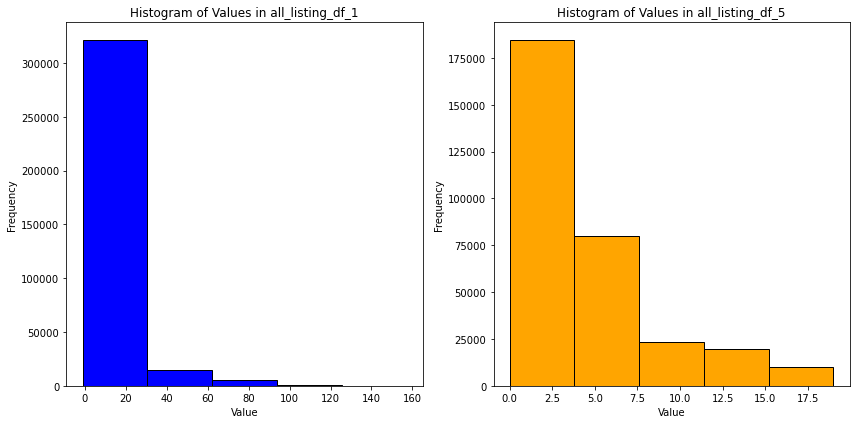

In [15]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

temp_df_1 = all_listing_df_1.copy()
temp_df_5 = all_listing_df_5.copy()

# Factorize 'property_type' for temporary DataFrames
temp_df_1['property_type'] = pd.factorize(temp_df_1['property_type'])[0]
temp_df_5['property_type'] = pd.factorize(temp_df_5['property_type'])[0]

plt.figure(figsize=(12, 6))

# Plot the histogram of 'property_type' in all_listing_df_1
plt.subplot(1, 2, 1)
temp_df_1['property_type'].plot(kind='hist', bins=5, edgecolor='black', color='blue')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values in all_listing_df_1')

# Plot the histogram of 'property_type' in all_listing_df_5
plt.subplot(1, 2, 2)
temp_df_5['property_type'].plot(kind='hist', bins=5, edgecolor='black', color='orange')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Histogram of Values in all_listing_df_5')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()


We can see that the distribution is heavily skewed in both the distribution and the histograms, so there are many categories that occur quite rarely. Thus, we can filter to keep the categories that capture 99.5% of the variation in property type

In [16]:
print(f"{len(all_listing_df_5['property_type'].unique())} out of {len(all_listing_df_4['property_type'].unique())} property types are greater than {threshold}")

rows_removed = len(all_listing_df_4) - len(all_listing_df_5)
print(f"Number of rows removed: {rows_removed}")
print(f"the property types remaining are: \n {all_listing_df_5['property_type'].unique()}")


20 out of 150 property types are greater than 0.005
Number of rows removed: 20343
the property types remaining are: 
 ['Entire rental unit' 'Entire loft' 'Private room in rental unit'
 'Private room in home' 'Entire condo' 'Entire home'
 'Private room in condo' 'Private room in townhouse'
 'Entire serviced apartment' 'Private room in bed and breakfast'
 'Entire townhouse' 'Entire guest suite' 'Entire villa' 'Room in hotel'
 'Room in boutique hotel' 'Entire guesthouse'
 'Private room in guest suite' 'Entire vacation home' 'Entire cottage'
 'Entire bungalow']


In [17]:
all_listing_df_5["room_type"].value_counts()

Entire home/apt    237997
Private room        80028
Name: room_type, dtype: int64

### Dealing with the property type

Since there are over 150 unique property types in the dataframe (but we think the type of listing will still be important for avaliability prediction), we want to try and reduce the number of categories for this variable

In [18]:
all_listing_df['property_type'].unique()

array(['Entire rental unit', 'Entire loft', 'Private room in rental unit',
       'Private room in home', 'Entire condo', 'Entire home',
       'Private room in castle', 'Private room in condo',
       'Private room in townhouse', 'Private room in loft',
       'Entire serviced apartment', 'Private room in casa particular',
       'Private room in hut', 'Private room in guesthouse',
       'Private room in villa', 'Tiny home', 'Room in boutique hotel',
       'Private room in bed and breakfast', 'Entire townhouse',
       'Entire guest suite', 'Entire villa', 'Shared room in hostel',
       'Room in hotel', 'Room in serviced apartment',
       'Room in bed and breakfast', 'Shared room in rental unit',
       'Entire guesthouse', 'Private room in guest suite', 'Barn', 'Boat',
       'Private room in serviced apartment',
       'Shared room in bed and breakfast', 'Private room in cabin',
       'Private room', 'Entire vacation home', 'Private room in chalet',
       'Private room in vaca

In [19]:
all_listing_df_5

,id,listing_url,host_name,host_since,host_location,host_response_time,host_response_rate,host_acceptance_rate,host_is_superhost,host_picture_url,...,review_scores_communication,review_scores_location,review_scores_value,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,location
0,73282.0,https://www.airbnb.com/rooms/73282,Simona,2011-02-04,"Zurich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/377532/profil...,...,4.93,4.71,4.61,f,1.0,1.0,0.0,0.0,0.39,Zurich
1,86645.0,https://www.airbnb.com/rooms/86645,James,2011-03-31,NaN,within an hour,100%,98%,t,https://a0.muscache.com/im/users/475053/profil...,...,4.77,4.60,4.47,t,17.0,17.0,0.0,0.0,0.36,Zurich
2,143821.0,https://www.airbnb.com/rooms/143821,Erhan,2011-06-13,"Zürich, Switzerland",NaN,NaN,0%,f,https://a0.muscache.com/im/users/697307/profil...,...,NaN,NaN,NaN,f,1.0,1.0,0.0,0.0,NaN,Zurich
3,178448.0,https://www.airbnb.com/rooms/178448,Delphine,2011-07-22,"Zurich, Switzerland",within an hour,100%,NaN,f,https://a0.muscache.com/im/users/854016/profil...,...,4.89,5.00,4.89,f,1.0,0.0,1.0,0.0,0.07,Zurich
4,204586.0,https://www.airbnb.com/rooms/204586,Aicha,2011-08-22,"Zurich, Switzerland",NaN,NaN,NaN,f,https://a0.muscache.com/im/users/1004816/profi...,...,NaN,NaN,NaN,f,1.0,0.0,1.0,0.0,NaN,Zurich
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
342230,32328992.0,https://www.airbnb.com/rooms/32328992,Viba Properties,2019-02-12,"Málaga, Spain",NaN,NaN,100%,t,https://a0.muscache.com/im/pictures/user/c271b...,...,4.84,4.84,4.75,t,1.0,1.0,0.0,0.0,0.74,Malaga
342231,50352276.0,https://www.airbnb.com/rooms/50352276,David,2021-06-12,NaN,NaN,NaN,100%,f,https://a0.muscache.com/im/pictures/user/17ef6...,...,NaN,NaN,NaN,t,1.0,1.0,0.0,0.0,NaN,Malaga
342232,32705544.0,https://www.airbnb.com/rooms/32705544,Alain,2011-08-05,"Andalusia, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/users/925118/profil...,...,4.97,4.86,4.87,t,6.0,6.0,0.0,0.0,2.02,Malaga
342233,33294303.0,https://www.airbnb.com/rooms/33294303,Sarah,2016-05-16,"Torremolinos, Spain",within an hour,100%,100%,t,https://a0.muscache.com/im/pictures/user/5e388...,...,5.00,5.00,4.82,t,4.0,4.0,0.0,0.0,0.41,Malaga


In [20]:
####################### DO ALL OF THE DATA VERIFICATION STUFF HERE ###############################

'''

Target:  For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.


Part 1: 

TO DO FOR DATA CHECKING + VERIFICATION:
- remove columns that have significant amount of NAN calues
- check that there is no property with number of available days > number of days in each  month 
- Check avalibalities (outcome variable) and make sure it is evenly distributed/ resample if needed 


TO DO FOR CONSISTENCY ANALYSIS:
- change dataframe to calculate avalaibilty per month and per location 
- plot average days avaliable for each city
- decide how to allocate consistent vs inconsistent cittes


Part 2:

RUN MODELS: 

Built and Run and test 2 models to try and predict monthly avaliabiltiy 

Model options: NN, linear regression 


'''



#the stuff below is to get the data needed to train the model once the dfs have been cleaned up

"\n\nTarget:  For our machine learning project, we want to try and predict a Airbnb's avaliability for a given month using listing data.\n\n\nPart 1: \n\nTO DO FOR DATA CHECKING + VERIFICATION:\n- remove columns that have significant amount of NAN calues\n- check that there is no property with number of available days > number of days in each  month \n- Check avalibalities (outcome variable) and make sure it is evenly distributed/ resample if needed \n\n\nTO DO FOR CONSISTENCY ANALYSIS:\n- change dataframe to calculate avalaibilty per month and per location \n- plot average days avaliable for each city\n- decide how to allocate consistent vs inconsistent cittes\n\n\nPart 2:\n\nRUN MODELS: \n\nBuilt and Run and test 2 models to try and predict monthly avaliabiltiy \n\nModel options: NN, linear regression \n\n\n"

## Consistency Analysis

### Creating dataset for average avaliability of listings per month per city

In [21]:

## add code that checks for the id 

def load_rental_data(city_name):
    """
    Load rental data for a specific city from a subdirectory.
    
    Parameters:
    - city_name (str): The name of the city.

    Returns:
    - pd.DataFrame: The loaded DataFrame.
    """
    # Construct the directory path based on the city name
    directory_path = f"home_rentals/{city_name}"
    
    # Assuming the file is named 'calendar.csv.gz'
    file_path = f"{directory_path}/calendar.csv.gz"
    
    try:
        # Load the DataFrame from the specified file
        df = pd.read_csv(file_path, compression='gzip')
        
        # You can perform additional processing on the DataFrame if needed
        
        # Return the loaded DataFrame
        return df
    except FileNotFoundError:
        # Handle the case where the file is not found
        print(f"Data not found for {city_name}. Check the directory path and file name.")
        return None
    

def filter_ids(df1, df2):
    """
    Filter out ID values in df1 that are not available in df2.

    Parameters:
    - df1 (pd.DataFrame): The first DataFrame.
    - df2 (pd.DataFrame): The second DataFrame.
    - id_column (str): The column containing the ID values.

    Returns:
    - pd.DataFrame: The filtered DataFrame.
    """
    id_column = "id"
    filtered_df = df1[df1["listing_id"].isin(df2["id"])]
    return filtered_df



def averageavaliability(city, latest_df):

    cityname = city
    citydata = load_rental_data(cityname) 

    #filter our ID's that are NOT present in our cleaned all_listings 

    filtered_citydata = filter_ids(citydata, latest_df)
    
    filtered_citydata["date"] = pd.to_datetime(filtered_citydata["date"])
    filtered_citydata["month"] = filtered_citydata["date"].dt.month
    filtered_citydata["year"] = filtered_citydata["date"].dt.year
    filtered_citydata['month_year'] = filtered_citydata['month'].astype(str) + '-' + filtered_citydata['year'].astype(str)

    # make a new data frame
    ave_month = (filtered_citydata[filtered_citydata['available'] == 't'].groupby(['listing_id', 'month_year']).size().unstack(fill_value=0).stack().reset_index(name='days_available'))
    
    # Calculate the average days_available for each month_year (making sure that it rounds to full numbers)
    ave_month = (ave_month.groupby('month_year')['days_available'].mean().round(0).reset_index(name='average_days_available'))
    # convert the month_year column to datetime format 
    ave_month['month_year'] = pd.to_datetime(ave_month['month_year'], format='%m-%Y').dt.to_period('M')

    # sort the rows by ascending dates
    ave_month = ave_month.sort_values('month_year')

    # reset the row index
    ave_month.reset_index(drop=True, inplace=True)

    ave_month['location'] = city

    return ave_month




In [ ]:
# Will take 10 mins to run but it WORKSSSSSS SLAY

all_locations = all_listing_df_5["location"].unique()

average_by_month = pd.DataFrame()

for location in all_locations:
    ave_month = averageavaliability(location, all_listing_df_5)
    average_by_month = pd.concat([average_by_month, ave_month], axis=0)
    print(location)


    # NOTE: For Madrid, the line "filtered_citydata = filter_ids(citydata, all_listing_df_5)" returns an empty df --> all listings have been 
    # removed from all_listing_df_5!!! Something has gone wrong, because all_listing_df_5 does have data for Madrid. something is wrong when 
    # the function uses it, idk why

In [23]:
average_by_month["location"].unique()


# THIS ARRAY IS MISSING A LOCATION (ONLY HAVE 26 INSTEAD OF 27)!!!! MISSING MADRID FOR SOME REASON, CHECK WHY!

array(['Zurich', 'Barcelona', 'Milan', 'Valencia', 'Mallorca',
       'Washington', 'Rotterdam', 'Tokyo', 'Los Angeles', 'Lisbon',
       'Ireland', 'Mexico City', 'Geneva', 'Euskadi', 'Vienna',
       'Vancouver', 'San Diego', 'Menorca', 'Naples', 'Toronto',
       'San Francisco', 'Winnipeg', 'Rome', 'Malta', 'Amsterdam',
       'Malaga'], dtype=object)

### Correcting for additional months

In [24]:
# check for the unique "month_year" vaues in the average_by_month dataframe. This allows us to see what months are covered by the data
average_by_month["month_year"].unique()

<PeriodArray>
['2022-09', '2022-10', '2022-11', '2022-12', '2023-01', '2023-02', '2023-03',
 '2023-04', '2023-05', '2023-06', '2023-07', '2023-08', '2023-09', '2023-10']
Length: 14, dtype: period[M]

In [25]:
# All of the locations should have data from 2022-09 until 2023-09
# loop through the dataframe and remove any month(s) for any locations that have observations over more than these 12 months

# Create a boolean mask based on the specified conditions
mask = average_by_month['month_year'] == "2023-10"

# Use the boolean mask to filter the DataFrame and keep only the rows that don't match the conditions
average_by_month = average_by_month[~mask]

# check that we got the result we wanted
average_by_month["month_year"].value_counts()


# ONLY 26 LOCATIONS INSTEAD OF 27??? WHY 



2022-09    26
2022-10    26
2022-11    26
2022-12    26
2023-01    26
2023-02    26
2023-03    26
2023-04    26
2023-05    26
2023-06    26
2023-07    26
2023-08    26
2023-09    26
Freq: M, Name: month_year, dtype: int64

As can be seen above, all of the locations have data ranging from 2022-09 to 2023-09, except for Euskadi which has an extra month of data (2023-10). This is an additional month in comparison to the other locations, as such we will remove it to have a consistent range of data between all of the locations. In addition, we can assume that the data for the 2023-10 is incorrect since it predicts there the month has already been fully booked, but when looking at the spread of data for the previous months (almost all of them have at least half of the month unbooked) this seems highly unlikely. 

In [26]:
''' 
TO DO FOR MODEL GENERATION:
- split the data set into test and train  
- etc. 
'''

# TO DO ELISA OVER WEEKEND
# fix weird error of missing location 
# GRAPH THE SEASONALITY (AKA CHECK AVAILABILITY PER MONTH PER LOCATION)
# Add a seasonality index column into the df for each location (a ratio between the different quarters of the year; look online for the eq) 
# --> From Chatty: seasonality index = (availbility / average avilability for that month) * 100%
# --> can find average availability using: data_frame['Average'] = data_frame.groupby('location')['availability'].transform('mean')

' \nTO DO FOR MODEL GENERATION:\n- split the data set into test and train  \n- etc. \n'

## Pricing Analysis
